# Just an example.You can alter sample code anywhere.

## mount your google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import packages


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import model

In [5]:
#Fix the random seed
np.random.seed(0)

## Load the data and label

In [6]:
train_load = np.loadtxt('./data/kmnist-train.csv',delimiter=',',dtype="int")
test_load = np.loadtxt('./data/kmnist-test.csv',delimiter=',',dtype="int")

train_data = train_load[:,1:]
train_label = train_load[:,0]
test_data=test_load
print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))
print("shape of test_data: {}".format(test_data.shape))

shape of train_data: (60000, 784)
shape of train_label: (60000,)
shape of test_data: (10000, 784)


## Show the training data

## Data Augmentation

In [7]:
def random_rotation(image, max_angle=45):
    angle = np.random.uniform(-max_angle, max_angle)
    rad = np.deg2rad(angle)
    cos, sin = np.cos(rad), np.sin(rad)

    h, w = image.shape[:2]
    rotation_matrix = np.array([[cos, -sin], [sin, cos]])

    # Compute the rotated coordinates
    new_image = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            coord = np.array([i - h // 2, j - w // 2])
            new_coord = np.dot(rotation_matrix, coord).astype(int) + [h // 2, w // 2]
            if 0 <= new_coord[0] < h and 0 <= new_coord[1] < w:
                new_image[new_coord[0], new_coord[1]] = image[i, j]

    return new_image

def random_shift(image, max_shift=5):
    dx = np.random.randint(-max_shift, max_shift)
    dy = np.random.randint(-max_shift, max_shift)

    h, w = image.shape[:2]
    new_image = np.zeros_like(image)

    # Shift the image
    for i in range(h):
        for j in range(w):
            new_i, new_j = i + dy, j + dx
            if 0 <= new_i < h and 0 <= new_j < w:
                new_image[new_i, new_j] = image[i, j]

    return new_image

def random_flip(image, horizontal=True, vertical=True):
    if horizontal and np.random.rand() > 0.5:
        image = np.fliplr(image)
    if vertical and np.random.rand() > 0.5:
        image = np.flipud(image)

    return image

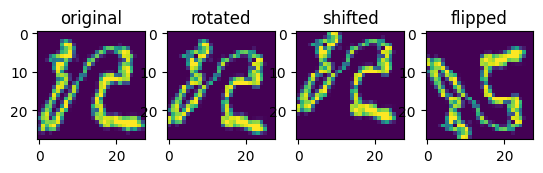

In [9]:
# Data augmentation demonstration
img = train_data[500].reshape(28, 28)
plt.subplot(1, 4, 1)
plt.title('original')
plt.imshow(img)
img = random_rotation(img)
plt.subplot(1, 4, 2)
plt.title('rotated')
plt.imshow(img)
img = random_shift(img)
plt.subplot(1, 4, 3)
plt.title('shifted')
plt.imshow(img)
img = random_flip(img)
plt.subplot(1, 4, 4)
plt.title('flipped')
plt.imshow(img)
plt.show()

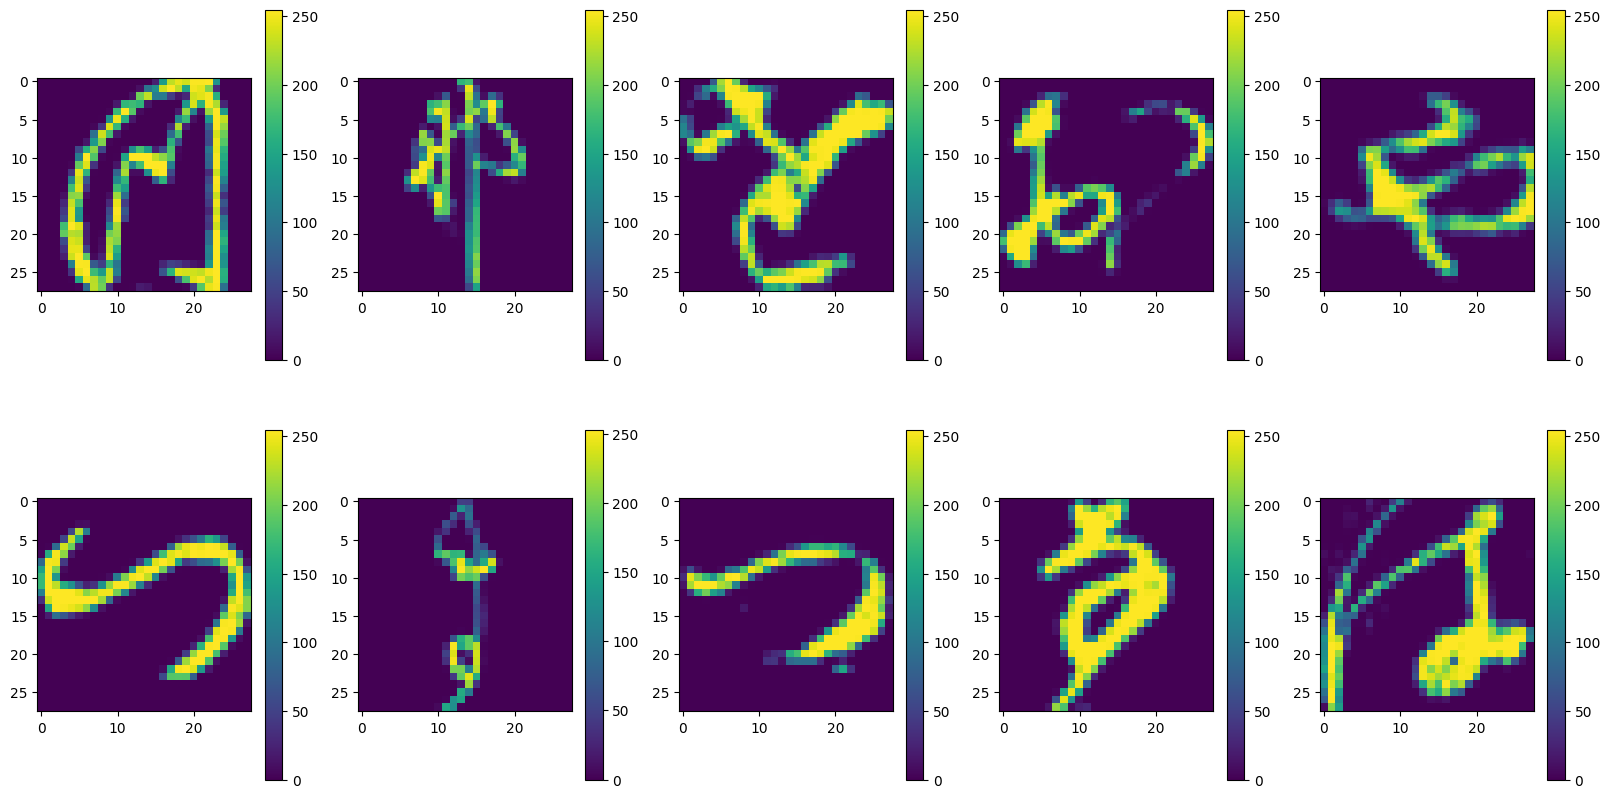

In [10]:
# View the original data
plt.figure(figsize=(20, 10))
for index in range(10):
   image = train_data[index+5000].reshape(28,28)
   plt.subplot(2, 5, index+1)
   plt.imshow(image)
   plt.colorbar()

plt.show()

In [13]:
def augment_data(data):
    augmented_data = []
    for img in data:
        img = img.reshape(28, 28)
        img = random_rotation(img)
        img = random_shift(img)
        # img = random_flip(img)
        img = img.flatten()
        augmented_data.append(img)
    return np.array(augmented_data)

augmented_train_data = augment_data(train_data)

In [20]:
def augment_image(image):
    # Random rotation
    image = image.reshape(28, 28)
    if np.random.rand() > 0.2:
        image = random_rotation(image)
    # Random shift
    if np.random.rand() > 0.2:
        image = random_shift(image)
    # Random flip
    # if np.random.rand() > 0.2:
    #     image = random_flip(image)
    return image.flatten()

In [15]:
# Combine original data & augmented data

# combined_train_data = np.concatenate((train_data, augmented_train_data))
# combined_train_label = np.concatenate((train_label, train_label))

# indices = np.arange(combined_train_data.shape[0])
# np.random.shuffle(indices)

# shuffled_train_data = combined_train_data[indices]
# shuffled_train_label = combined_train_label[indices]

# train_data = shuffled_train_data
# train_label = shuffled_train_label

In [12]:
train_image_num = train_data.shape[0]
test_image_num = test_data.shape[0]
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
train_data = train_data/255.0
test_data = test_data/255.0

print("train_image_num  is : {}".format(train_image_num))
print("test_image_num   is : {}".format(test_image_num))

train_image_num  is : 60000
test_image_num   is : 10000


## Validation image number

In [13]:
val_image_num = 10000

## Convert the training labels to one hot vector

In [14]:
label_temp = np.zeros((train_image_num, 10), dtype = np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
print("One-hot training labels shape:",train_label_onehot.shape)

One-hot training labels shape: (60000, 10)


## Hyperparameters

In [15]:
EPOCH = 30
Batch_size = 50
Learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

## Training

In [21]:
# please make sure you have place layer.py & network.py in 'model' folder
net = model.Network()

train_batch_num = (train_image_num - val_image_num)//Batch_size
val_batch_num = (val_image_num)//Batch_size

for epoch in range(1, EPOCH+1):
    train_hit = 0
    val_hit = 0
    total_train_loss = 0.0
    total_val_loss = 0.0

    # Training loop with on-the-fly augmentation
    for it in range(train_batch_num):
        # Apply augmentation to each image in the batch
        batch_data = train_data[it*Batch_size:(it+1)*Batch_size]
        augmented_batch_data = np.array([augment_image(img) for img in batch_data])

        # Forward pass with augmented data
        pred, train_loss = net.forward(augmented_batch_data, train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        pred_index = np.argmax(pred, axis=1)
        train_hit += (pred_index == train_label[it*Batch_size:(it+1)*Batch_size]).sum()
        total_train_loss += train_loss

        # Backward pass and update
        net.backward()
        net.update(Learning_rate, beta1, beta2, epsilon)

    # Validation loop (no augmentation)
    for titt in range(val_batch_num):
        tit = train_batch_num + titt
        pred, val_loss = net.forward(train_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
        pred_index = np.argmax(pred, axis=1)
        val_hit += (pred_index == train_label[tit*Batch_size:(tit+1)*Batch_size]).sum()
        total_val_loss += val_loss

    print('Task1  | Epoch:%3d'%epoch,
          ' |Train Loss:%8.4f'%(total_train_loss/train_batch_num),
          ' |Train Acc:%3.4f'%(train_hit/(train_image_num-val_image_num)*100.0),
          ' |Val Loss:%8.4f'%(total_val_loss/val_batch_num),
          ' |Val Acc:%3.4f'%(val_hit/val_image_num*100.0))

Task1  | Epoch:  1  |Train Loss:  1.3636  |Train Acc:55.6520  |Val Loss:  0.8528  |Val Acc:77.1500
Task1  | Epoch:  2  |Train Loss:  1.0755  |Train Acc:65.8540  |Val Loss:  0.6766  |Val Acc:81.7400
Task1  | Epoch:  3  |Train Loss:  0.9632  |Train Acc:69.2860  |Val Loss:  0.6339  |Val Acc:82.1200
Task1  | Epoch:  4  |Train Loss:  0.8847  |Train Acc:71.6920  |Val Loss:  0.5881  |Val Acc:83.1800
Task1  | Epoch:  5  |Train Loss:  0.8378  |Train Acc:73.2640  |Val Loss:  0.5484  |Val Acc:84.5000
Task1  | Epoch:  6  |Train Loss:  0.7932  |Train Acc:74.9940  |Val Loss:  0.5223  |Val Acc:84.9900
Task1  | Epoch:  7  |Train Loss:  0.7620  |Train Acc:75.7820  |Val Loss:  0.4813  |Val Acc:86.3200
Task1  | Epoch:  8  |Train Loss:  0.7391  |Train Acc:76.5120  |Val Loss:  0.4867  |Val Acc:86.1700
Task1  | Epoch:  9  |Train Loss:  0.7142  |Train Acc:77.4260  |Val Loss:  0.4775  |Val Acc:86.0500
Task1  | Epoch: 10  |Train Loss:  0.6935  |Train Acc:78.1160  |Val Loss:  0.4761  |Val Acc:85.9600
Task1  | E

In [ ]:
for epoch in range(31, 40):
    train_hit = 0
    val_hit = 0
    total_train_loss = 0.0
    total_val_loss = 0.0
    for it in range(train_batch_num):
        pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        pred_index = np.argmax(pred, axis=1)
        train_hit += (pred_index==train_label[it*Batch_size:(it+1)*Batch_size]).sum()
        total_train_loss += train_loss

        net.backward()
        net.update(Learning_rate)

    for titt in range(val_batch_num):
        tit=train_batch_num+titt
        pred, val_loss = net.forward(train_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
        pred_index = np.argmax(pred, axis=1)
        val_hit += (pred_index==train_label[tit*Batch_size:(tit+1)*Batch_size]).sum()
        total_val_loss += val_loss

    print('Task1  | Epoch:%3d'%epoch, ' |Train Loss:%8.4f'%(total_train_loss/train_batch_num), ' |Train Acc:%3.4f'%(train_hit/(train_image_num-val_image_num)*100.0)
          , ' |Val Loss:%8.4f'%(total_val_loss/val_batch_num), ' |Val Acc:%3.4f'%(val_hit/val_image_num*100.0))

## Dump for evaluation (upload your DL-test-predict.csv to kaggle )

In [29]:
test_pred_list = []
total_test = 0
for tit in range(test_image_num//Batch_size):
    pred, _ = net.forward(test_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
    pred_index = np.argmax(pred, axis=1)
    test_pred_list += pred_index.tolist()
    total_test += Batch_size

print('Please make sure that total test images = 10000')
print(f'Total test images: {total_test} ')

print('Dump file...')
df = pd.DataFrame(test_pred_list, columns=["Category"])
df.to_csv('DL-test-predict.csv', index=True, index_label="Id")

Please make sure that total test images = 10000
Total test images: 10000 
Dump file...
